<h1><center>Introduction to Fixed Point Signal Processing</center></h1>
<center>Ayan Shafqat</center>
<center>ans343@nyu.edu</center>
<center>December 5, 2020</center> 






# Background

In 1927, Alan Turing's paper discussed a class of numbers called *finite and
computable numbers*. This allowed for the construction of digital computer.
Signal processing, in essence, is the study of converting real-world
signal into finite and computable numbers, and processing them with 
the fewest bits possible.

# What are fixed-point numbers?
* Over the years, computers had different encoding schemes for representing and processing numerical data
  * **Binary coded decimal**: Still used today for financial calculations, inefficient.
  * **Binary one's complement**: Used by early computers like [Apollo Guidance Computer](
     https://en.wikipedia.org/wiki/Apollo_Guidance_Computer). Very rare to see a
     computer with this numeric encoding for integers. However, [IEEE 754](
     https://en.wikipedia.org/wiki/IEEE_754) floating point encoding are indeed one's complement.
  * **Binary two's complement**: Most common implementation for integers for all major
    architectures, including x86, ARM, RISC-V and many DSP
  * **Floating point**: Makes writing math expressions easy, there are several standards
    and extension. [IEEE 754](https://en.wikipedia.org/wiki/IEEE_754), [Posit Unum III](
    https://en.wikipedia.org/wiki/Unum_(number_format)#Unum_III)
  * **Bignum**: Arbitrary precission arithmetic, used for cryptography, mathmatics, etc.
  * There are otheres: Logarithmic numbers, Computer algebra system (CAS), etc.
* **Fixed-point** in this context means binary two's complement numbers with scaling
   factor for fractions.

# It’s the 2020’s, do we still need fixed point arithmetic for signal processing?

* Floating point machines are more common now, but that was not the case all the time.
* FPUs (a.k.a  math coprocessor) were expensive and slow!
  * Intel 8087 costed around [\$375 in 1985](https://books.google.com/books?id=0C4EAAAAMBAJ&lpg=PA27&ots=z8RRGv5UvJ&dq=intel%20personal%20computer%20enhancement%208087%20price&pg=PA27#v=onepage&q=intel%20personal%20computer%20enhancement%208087%20price&f=false), [$915.15 in 2020 USD](https://www.usdinflation.com/amount/375)
  * FPU was uncommon in desktop computers (extra headache for programmers)
* Most programs were written without the support of FPU 
* In the past, fixed point signal processing was mainstream
  * Speak & Spell used [TMS5100](https://en.wikipedia.org/wiki/Texas_Instruments_LPC_Speech_Chips) for speech synthesis (70’s)
  * AT&T’s used [DSP1](https://www.computerhistory.org/siliconengine/single-chip-digital-signal-processor-introduced/) for call routing (80’s)
  * NeXTcube and ProTools used [Motorola 56001
    ](https://www.computerhistory.org/siliconengine/single-chip-digital-signal-processor-introduced/) DSP to process image and audio (90’s)
* To answer the question: It depends on various costs and benefits

# Pros and cons

* On one hand, doing signal processing in floating point offers:
  * Greater dynamic range
  * Less development time
  * Precision 
* Fixed point is still best at:
  * Minimizing cost: Less logic gates are needed to operate on integers than floating 
  * Efficient power utilization
  * More bandwidth utilization (less bits)

# Where are fixed point arithmetic done today?
* Your phones modem: 3G, LTE, and now 5G, where FPGAs are involved for software defined radios
* Wearable electronics: BlueTooth earbuds, smart watch, smart glasses, etc.
* Physical layer network communication: Fiber-optic, Satellite, etc.
* Special purpose accelerators: Convolutional neural network engines, audio/video codec, image processors
* Operating systems kernel (i.e. Linux, XNU): Cannot execute floating point math in kernel-mode

# Getting Started with Fixed-point Arithmetic
* Know the Q notation
* The Q notation convention describes binary fixed point number scaling and bits
* Written as Q**n**.**m**, where **m** is the number of bits reserved for integer
  portion and **n* is the number of bits reserved for fractional portion.
* Sometimes **m** is not indicated in the notation if there are no bits reserved for integer
  bits or sign bit
    * For example `Q15` is used to decribe the format of 16-bit PCM format used by CDs
      (you know... those shiny disks). `Q15` can also be written as `Q1.15`, where there
      are 15 bits reserved for fraction and 1 bit for sign.
    * CD audio has a range of `[-1.0, +0.999969482421875]`
    * What happened to +1.0?
* Sometimes **U** is used to describe unsigned
    * 8-bit PCM samples tend have a bias ($s + 127$) in their
      format, typically `U8` is used to describe that format.
* Sometimes `S16` is used to represent `Q1.15` as well

## How to get the range of values for a certain fixed-point type:

$$Q(m,n) \in \mathbb{Z} : [-2^{m-1}, 2^{m-1} - 2^{-n}]$$

## What is the resolution of a certain fixed-point type:

$$ 2^{-n} $$

What is the resolution for a 32-bit floating point type? Extra credit.

In [1]:
def qrange(m, n):
    """Get numeric range of _signed_ Qm.n integers
    
    Args:
        m: Number of bits for integer portion
        n: Number of bits for fraction portion

    Returns:
        tuple(min_value, max_value)
    """
    from numpy import ldexp
    min_value = ldexp(-1.0, m - 1)
    max_value = ldexp(+1.0, m - 1) - ldexp(1.0, -n)
    return (min_value, max_value) 

# How to convert decimal to fixed point

Given $Q(m, n)$, for a given value $x$, quantized fixed point value, $y$ is:

$$y = \lceil2^{n}x\rfloor$$


May want to saturate the results so they don't overflow in fixed point:

$$\text{clip}\left(x, m, n\right) := \max\left(-2^{m - 1}, \min\left(x, 2^{m - 1} - 2^{-n}\right)\right)$$

So final expression:

$$y = \lceil2^{n}\text{clip}\left(x, m, n\right)\rfloor$$

In [2]:
from numpy import clip, ldexp, rint


def ftoq(x, m, n):
    """Convert a float value to fractional integer
    
    Args:
        x: A double/float value
        m: Bits for integer portion
        n: Scaling factor from Q notation
        
    Returns:
        np.array_like(int)
    """
    vmin, vmax = qrange(m, n)
    return int(rint(ldexp(clip(x, vmin, vmax), n)))

In [3]:
def qtof(x, m, n):
    """Convert a fractional integer to float
    
    Args:
        x: A double/float value
        m: Number of bits for integer portion
        n: Number of bits for fraction portion
    
    Returns:
        np.array_like(float)
    """
    vmin, vmax = qrange(m, n)
    return clip(ldexp(float(x), -n), vmin, vmax)

In [4]:
from numpy import vectorize

vftoq = vectorize(ftoq)
vqtof = vectorize(qtof)

def vquantize(x, m, n):
    return vqtof(vftoq(x, m, n), m, n)

In [5]:
print("\n".join(f"{n: 1.08f} -> {ftoq(n, 1, 15): 6d}" for n in (0.5, 0.707, 0.99999999)))
print("\n".join(f"{n: 6d} -> {qtof(n, 1, 15): 1.08f}" for n in (16384, 23168, 32767)))

 0.50000000 ->  16384
 0.70700000 ->  23167
 0.99999999 ->  32767
 16384 ->  0.50000000
 23168 ->  0.70703125
 32767 ->  0.99996948


# Exercise

Suppose you are working on a thermostat for ACME Corporation. In order to reduce production and power costs, they have decided to choose a microprocessor without an FPU. Your job is to take temperature data from the sensor, which outputs in Celsius, and convert it to Fahrenheit for the user interface team. They want to be able to display up to 1 decimal place accurately. You are free to decide on the appropriate `QM.N` format. Note, the formula for convertion is:

$$F = \frac{9}{5} C + 32$$

1. How many bits are needed for fractional portion in order to achieve one decimal place of accuracy?
1. Given temperature sensor has a range of -100° to 155° in Celsius, which corresponds to roughly -150° to +310°
   degrees Fahrenheit. How many bits do we need for the integer portion?

In [6]:
from numpy import log2, ceil

# Question: How many bits do we need to compute this result?

n = 1  # Decimal places
print(f"Numbers of bits needed for {n} decimal places accuracy: {ceil(abs(log2(10 ** (-n))))}")

# Question: Given temperature sensor has a range of -100 to 155 in Celsius,
# which corresponds to roughly -150 to +310 degrees Fahrenheit. How many bits
# do we need for the integer portion?
n = 310
print(f"Bits needed to store up to {n}: {ceil(log2(n))}")

# Let's give it some room and use an extra two bits for quantization error.
# Also, one extra bit is needed for sign, thus a format of Q10.6 is needed.

# The computation can be done using 16 bit signed integers at Q10.6 format
# Note the formula: F = 9/5 * C + 32

Numbers of bits needed for 1 decimal places accuracy: 4.0
Bits needed to store up to 310: 9.0


In [7]:
ftoq(9/5, 10, 6), ftoq(32.0, 10, 6), qtof(-7404, 10, 6)

(115, 2048, -115.6875)

In [8]:
# Reference function for comparison

def ctof_f64(c):
    """Convert Celsius to Fahrenheit
    
    Args:
        c: Celsius
    
    Return:
        Fahrenheit
    """
    return 9/5 * c + 32.0

In [9]:
def ctof_q10x6(c):
    """Convert Celsius to Fahrenheit in Q10.6 format
    
    Args:
        c: Celsius in Q10.6 format
    
    Return:
        int16(Q10.6)
    """
    C0 = int16(ftoq(9/5, 10, 6))
    C1 = int16(ftoq(32,  10, 6))
    return q10x6mul(C0, c) + C1

In [10]:
from numpy import int32, int16, clip

def qround(a, b):
    """Round an integer `a` by `b`"""
    if a < 0:
        a = a - b
    else:
        a = a + b
    return a


def q10x6mul(a, b):
    """Multiply two Q10.6 integers"""
    a = int32(a)
    b = int32(b)
    c = a * b                   # c: Q20.12
    c = qround(c, 0b10000)      # Round to nearest b0.000001 bit
    c = c >> 6                  # Rescale c to Q10.6
    c = clip(c, -32768, 32767)  # Saturate result
    return int16(c)

In [11]:
from numpy import linspace

print("Celsius \tQ10.6 \t\tF64 \t\tError")

for c in linspace(-100, 155, num=15):
    cq10x6 = ftoq(c, 10, 6)
    fq10x6 = ctof_q10x6(cq10x6)
    f = ctof_f64(c)
    fq = qtof(fq10x6, 10, 6)
    perr = abs(f - fq) / f * 100
    print(f"{c: 3.1f}° C \t{fq: 3.1f}° F \t{f: 3.1f}° F \t {perr: 2.2} %")
    

Celsius 	Q10.6 		F64 		Error
-100.0° C 	-147.7° F 	-148.0° F 	 -0.2 %
-81.8° C 	-115.0° F 	-115.2° F 	 -0.21 %
-63.6° C 	-82.2° F 	-82.4° F 	 -0.22 %
-45.4° C 	-49.5° F 	-49.6° F 	 -0.26 %
-27.1° C 	-16.8° F 	-16.9° F 	 -0.45 %
-8.9° C 	 16.0° F 	 15.9° F 	  0.15 %
 9.3° C 	 48.7° F 	 48.7° F 	  0.087 %
 27.5° C 	 81.4° F 	 81.5° F 	  0.12 %
 45.7° C 	 114.1° F 	 114.3° F 	  0.13 %
 63.9° C 	 146.9° F 	 147.1° F 	  0.14 %
 82.1° C 	 179.6° F 	 179.9° F 	  0.15 %
 100.4° C 	 212.3° F 	 212.6° F 	  0.15 %
 118.6° C 	 245.1° F 	 245.4° F 	  0.15 %
 136.8° C 	 277.8° F 	 278.2° F 	  0.16 %
 155.0° C 	 310.5° F 	 311.0° F 	  0.16 %


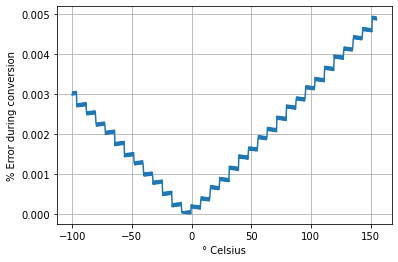

In [12]:
import matplotlib.pylab as plt
from numpy import linspace, vectorize
vctof_q10x6 = vectorize(ctof_q10x6)
c = linspace(-100, 155, num=512)
cq = vftoq(c, 10, 6)
fq = vctof_q10x6(cq)
fq = vqtof(fq, 10, 6)
f = ctof_f64(c)
perr = abs(f - fq)/100.0
plt.plot(c, perr)
plt.grid(True)
plt.xlabel("° Celsius")
plt.ylabel("% Error during conversion")
plt.show()

# Fixed point signal processing

* There are only two rules of fixed point signal processing:
    * Thou shalt not overflow
    * Thou shalt not underflow
* Always design your filters so they are within range of operation
    * Usually with FIR filters, it is not a problem
    * IIR filters become a challenge, can be avoided with low order filters


# FIR filters in fixed-point

```C
#include <stdint.h>

typedef int16_t q15_t;

typedef struct fir_instance_q15
{
    q15_t    *coeff;
    q15_t    *state;
    uint32_t index;
    uint32_t taps;
} fir_q15_t;

void generic_fir_q15(fir_q15_t     *self, 
                     q15_t         *dst, 
                     const q15_t   *src,
                     uint32_t      frames);
```

1. CMSIS DSP documentation for [fixed-point FIR filter](https://arm-software.github.io/CMSIS_5/DSP/html/group__FIR.html#gad9f84fdadbb59292592c7fac81adb09c)
1. CMSIS DSP implementation for FIR filter [arm_fir_q15.c](https://github.com/ARM-software/CMSIS/blob/f2cad4345783c948ed4a7f5cdb02cdc0856366f1/CMSIS/DSP_Lib/Source/FilteringFunctions/arm_fir_q15.c#L603)


In [13]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from zplane import zplane


def plot_response(fs, w, h, title, sb=-40):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(sb, 5)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)
    

def sos2zpk(sos):
    b, a = signal.sos2tf(sos)
    z, p, k = signal.tf2zpk(b, a)
    return z, p, k

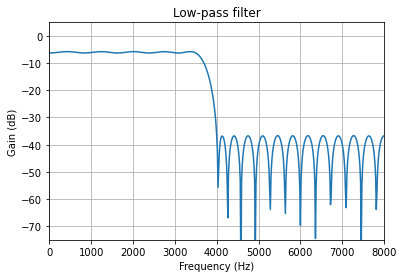

In [14]:
Fs = 16000.0  # Sample Rate: Hz
Fc = 3500.0   # Cutoff frequency: Hz
Tw = 500.0    # Transition width: Hz
ntaps = 45    # Filter taps
gain = 0.5    # Filter gain to avoid overflow
# Generate the FIR filter
coeffs = gain * signal.remez(ntaps, [0, Fc, Fc + Tw, Fs/2.0], [1, 0], Hz=Fs)
qcoeffs = vquantize(coeffs, 1, 15)
# Get filter response
w, h = signal.freqz(qcoeffs, [1], worN=512)
plot_response(Fs, w, h, "Low-pass filter", sb=-75)

In [15]:
coeff_str = ",".join(f"{x:d}" for x in vftoq(coeffs, 1, 15))
taps = coeffs.shape[0]
print("/*<autogen-fir>*/")
print(f"q15_t fir_coeff[{taps}] = {{{coeff_str}}};")
print(f"q15_t fir_state[{taps}] = {{0}};");
print(f"uint32_t fir_taps = {taps};")
print(f"uint32_t fir_index = 0;")
print(f"fir_q15_t fir_filter = {{ fir_coeff, fir_state, fir_index, fir_taps }};")
print("/*</autogen-fir>*/")

/*<autogen-fir>*/
q15_t fir_coeff[45] = {171,-201,-209,1,148,-33,-230,-29,271,90,-326,-188,375,328,-420,-537,458,888,-487,-1643,506,5183,7681,5183,506,-1643,-487,888,458,-537,-420,328,375,-188,-326,90,271,-29,-230,-33,148,1,-209,-201,171};
q15_t fir_state[45] = {0};
uint32_t fir_taps = 45;
uint32_t fir_index = 0;
fir_q15_t fir_filter = { fir_coeff, fir_state, fir_index, fir_taps };
/*</autogen-fir>*/


# IIR filters in fixed-point

```C
#include <stdint.h>

typedef int16_t q15_t;

typedef struct iir_instance_q15
{
    q15_t    *coeff; /* b0, b1, b2, a1, a2... */
    q15_t    *state; /* x1, x2, y1, y2, ... */  
    uint32_t nstage;
    int32_t  shift;
} iir_q15_t;

void generic_iir_q15(iir_q15_t     *self, 
                     q15_t         *dst, 
                     const q15_t   *src,
                     uint32_t      frames);
```

1. CCRMA's info on [Direct form I](https://ccrma.stanford.edu/~jos/filters/Direct_Form_I.html)
1. CMSIS DSP documentation on [fixed-point IIR filters](https://arm-software.github.io/CMSIS_5/DSP/html/group__BiquadCascadeDF1.html#ga27af5bfa40dad7c877e48eedc8d67558)
1. CMSIS DSP implementation of IIR filter [arm_biquad_cascade_df1_q15.c](https://github.com/ARM-software/CMSIS/blob/f2cad4345783c948ed4a7f5cdb02cdc0856366f1/CMSIS/DSP_Lib/Source/FilteringFunctions/arm_biquad_cascade_df1_q15.c#L75)

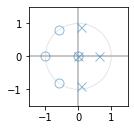

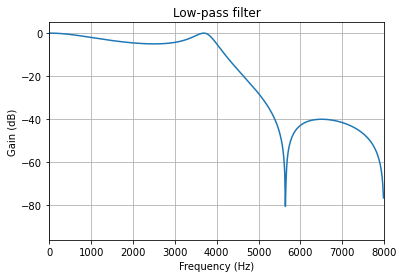

In [16]:
Fs = 16000.0 # Sample Rate: Hz
Fc = 4000.0  # Cutoff frequency: Hz
sos = signal.iirfilter(3, Fc, rs=40, rp=5, btype='low', analog=False, ftype='ellip', fs=Fs, output='sos')
qsos = vquantize(sos, 2, 14)
w, h = signal.sosfreqz(qsos)
z, p, k = sos2zpk(qsos)
zplane(z, p)
plot_response(Fs, w, h, "Low-pass filter", sb=-96)

In [21]:
print(sos)

sos2 = np.delete(sos, 3, axis=1).flatten()                  # Remove a0 column
coeff_str = ",".join(f"{x:d}" for x in vftoq(sos2, 3, 13))  # "flatten" array so it's one dimention
iir_stage = sos.shape[0]                                    # Get number of stages
iir_shift = 13                                              # Get the shift amount

# Write out header file
print("/*<autogen-iir>*/")
print(f"#define NSTAGE ({iir_stage})")
print(f"q15_t iir_coeff[5 * NSTAGE] = {{{coeff_str}}};")
print(f"q15_t iir_state[4 * NSTAGE] = {{0}};")
print(f"uint32_t iir_stage = NSTAGE;")
print(f"int32_t iir_shift = {iir_shift};")
print(f"iir_q15_t iir_filter = {{iir_coeff, iir_state, iir_stage, iir_shift}};")
print("/*</autogen-iir>*/\n")

[[ 0.09785746  0.09785746  0.          1.         -0.61870658  0.        ]
 [ 1.          1.20325498  1.          1.         -0.17021587  0.8144215 ]]
/*<autogen-iir>*/
#define NSTAGE (2)
q15_t iir_coeff[5 * NSTAGE] = {802,802,0,-5068,0,8192,9857,8192,-1394,6672};
q15_t iir_state[4 * NSTAGE] = {0};
uint32_t iir_stage = NSTAGE;
int32_t iir_shift = 13;
iir_q15_t iir_filter = {iir_coeff, iir_state, iir_stage, iir_shift};
/*</autogen-iir>*/



In [18]:
x = np.zeros(32)
x[0] = 1
y = signal.sosfilt(vquantize(sos, 2, 14), x)
ys = signal.sosfilt(vquantize(sos, 2, 14), np.ones(32))
print(f"Impulse response:\n {y}")
print(f"Step response: \n{ys}")

Impulse response:
 [ 0.09783936  0.2927537   0.35654529  0.15918156 -0.05482352 -0.00999962
  0.1227405   0.07840751 -0.05606584 -0.05449918  0.04807553  0.05980219
 -0.02449616 -0.05010284  0.01313415  0.04409932 -0.0025335  -0.03593957
 -0.00380352  0.0287768   0.00809227 -0.0219986  -0.01029824  0.01618521
  0.01115605 -0.01127333 -0.01099904  0.00731191  0.01020428 -0.00421644
 -0.00902725  0.00189765]
Step response: 
[0.09783936 0.39059305 0.74713834 0.9063199  0.85149637 0.84149676
 0.96423726 1.04264477 0.98657893 0.93207975 0.98015529 1.03995748
 1.01546132 0.96535848 0.97849263 1.02259195 1.02005845 0.98411889
 0.98031536 1.00909216 1.01718443 0.99518583 0.98488759 1.0010728
 1.01222885 1.00095552 0.98995649 0.9972684  1.00747268 1.00325623
 0.99422899 0.99612664]


# Other functions

1. Trigonometry: [libfixmath](https://en.wikipedia.org/wiki/Libfixmath) offers a great set of math functions for your fixed point needs.
1. [CMSIS](https://www.arm.com/why-arm/technologies/cmsis) and [CMSIS-DSP](https://github.com/ARM-software/CMSIS_5), A great library for programming for embedded ARM environment. Supported by ARM!
1. Espressif, a new player in slilcon industry from China, has a great set of DSP libraries [esp-dsp](https://github.com/espressif/esp-dsp)
1. [PLUP DSP](https://github.com/pulp-platform/pulp-dsp) is an open source FPGA DSP that is based on RISC-V architecture.

# Questions/Comments

Thank you for your time.